This notebook replicates selected figures from Gao et al., 2018. **A cortico-cerebellar loop for motor planning**
<br>
Link to the publication:  https://www.nature.com/articles/s41586-018-0633-x
<br>

<br>


In [1]:
%matplotlib notebook

In [2]:
import datajoint as dj
from pipeline import ephys, behavior, subject, acquisition
import numpy as np
import matplotlib.pyplot as plt
from pipeline import get_spk_counts, get_trials, get_spk_times, get_psth
import scipy.signal as signal
import scipy.stats as ss
import datetime
import numpy.random as random

Connecting shan@host.docker.internal:3306


## Figure 2c

In [3]:
# helper function
def compute_mean_and_sem(fr):
    mean_fr = np.average(fr, axis=0)
    sem_fr = np.divide(np.std(fr, axis=0), np.sqrt(np.shape(fr)[0]))
    return mean_fr, sem_fr

In [4]:
# restrict to photo activation sessions
sessions = acquisition.Session & (behavior.TrialSetType & 'trial_set_type = "photo activation"')

# restrict to pyramidal cells, no light trials, only hit trials, trial number > 15
valid_cells = (ephys.UnitSelectivity & sessions & 
           (ephys.UnitSpikeTimes & 'unit_cell_type = "pyramidal"') & 
           'trial_condition = "Hit"' &
           'l_trial_number > 15' &
           'r_trial_number > 15' & 'selectivity=1')

# restrict to selective units
fr_diff, bins = valid_cells.fetch('psth_diff_test', 'bins')
fr_diff = np.array(fr_diff.tolist())

In [5]:
mean_fr, sem_fr = compute_mean_and_sem(fr_diff)

In [6]:
xlim = [-3, 2]
ylim = [-1, 4]
time_points = [-2.6, -1.3, 0]

<IPython.core.display.Javascript object>


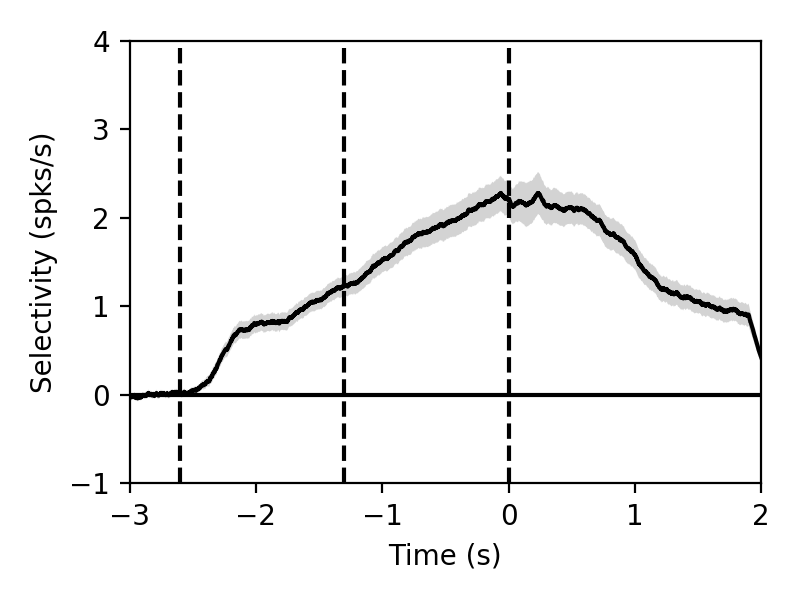

In [7]:
fig, ax = plt.subplots(1, 1, figsize=[4,3])
for time_point in time_points:
    ax.axvline(x=time_point, color='black', linestyle='dashed')
ax.axhline(y=0, color='black')
ax.fill_between(bins[0], mean_fr+sem_fr, mean_fr-sem_fr, facecolor="lightgray")
ax.plot(bins[0], mean_fr, color="black")
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Selectivity (spks/s)')
fig.tight_layout()

## Figure 3 e, f

In [9]:
# restrict to photo inhibition sessions
sessions = acquisition.Session & (behavior.TrialSetType & 'trial_set_type = "photo inhibition"')

# light off condition
light_off = ephys.UnitSelectivity & sessions & \
              (ephys.UnitSpikeTimes & 'unit_cell_type = "pyramidal"') &\
              'selectivity > 0' & 'trial_condition = "All"'
light_on = ephys.AlignedPsthStimOn & sessions & light_off &  'photo_stim_id="6"'& \
              (ephys.UnitSpikeTimes & 'unit_cell_type = "pyramidal"') & 'trial_condition = "All"'

fr_diff_off, bins = light_off.fetch('psth_diff_test', 'bins')
fr_diff_on = light_on.fetch('psth_diff_on')

fr_diff_off = np.array(fr_diff_off.tolist())
fr_diff_on = np.array(fr_diff_on.tolist())

In [10]:
mean_fr_off, sem_fr_off = compute_mean_and_sem(fr_diff_off)
mean_fr_on, sem_fr_on = compute_mean_and_sem(fr_diff_on)

In [11]:
mean_fr = [mean_fr_off, mean_fr_on]
sem_fr = [sem_fr_off, sem_fr_on]

<IPython.core.display.Javascript object>


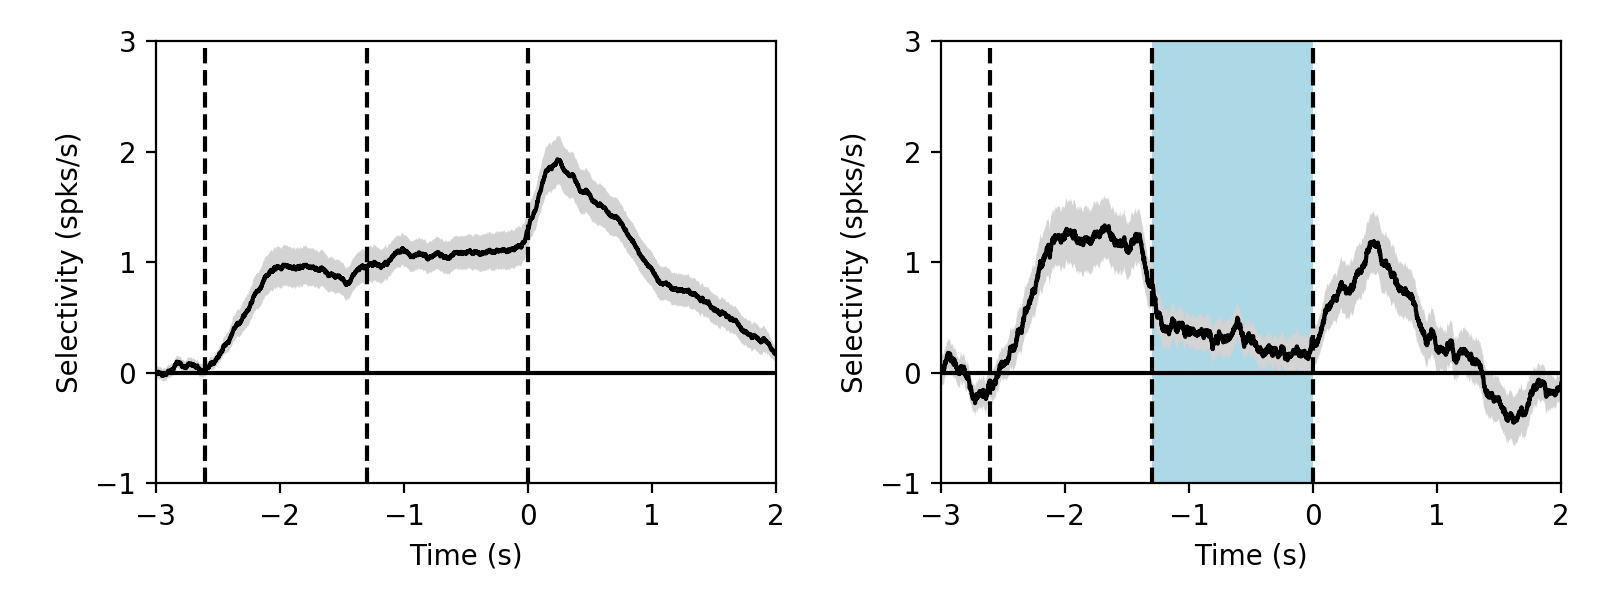

In [12]:
ylim = [-1, 3]
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(8,3))
for ix, ax in enumerate(axs):
    for time_point in time_points:
        ax.axvline(x=time_point, color='black', linestyle='dashed')
    if ix == 1:
        ax.fill_between(time_points[1:], [ylim[0], ylim[0]], [ylim[1], ylim[1]], facecolor="lightblue")
    ax.axhline(y=0, color='black')
    ax.fill_between(bins[0], mean_fr[ix]+sem_fr[ix], mean_fr[ix]-sem_fr[ix], facecolor="lightgray")
    ax.plot(bins[0], mean_fr[ix], color="black")
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Selectivity (spks/s)')

fig.tight_layout()
fig.savefig('/images/photo_inhibition.png', dpi=300)

In [13]:
selectivity, fr_light_off, fr_light_on = (ephys.UnitSelectivity() * ephys.AlignedPsthStimOn & 
                                          'photo_stim_id="6"' & sessions & \
              (ephys.UnitSpikeTimes & 'unit_cell_type = "pyramidal"') &\
               'trial_condition = "All"').fetch(
    'mean_fr_diff_rl_all', 'mean_fr_all', 'mean_fr_all_on')

In [14]:
selectivity = [fr[1] for fr in selectivity]
fr_diff_photo = [fr_on[1] - fr_off[1] for fr_off, fr_on in zip(fr_light_off, fr_light_on)]

<IPython.core.display.Javascript object>


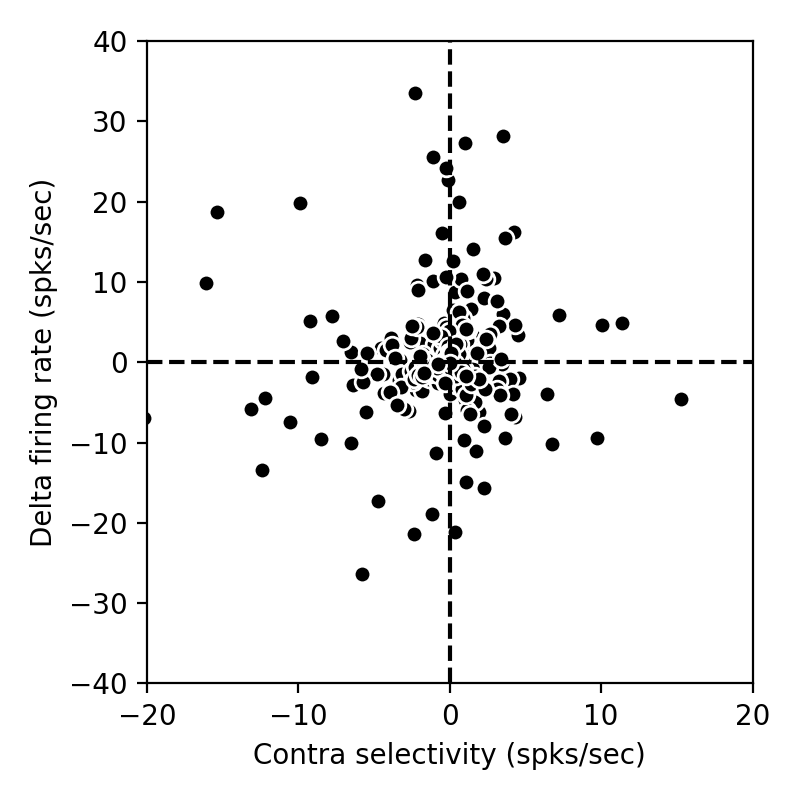

In [17]:
fig2, ax = plt.subplots(1, 1, figsize=[4,4])
ax.scatter(selectivity, fr_diff_photo, color='k', edgecolors='w')
ax.set_xlim([-20, 20])
ax.set_ylim([-40, 40])
ax.axvline(x=0, color='black', linestyle='dashed')
ax.axhline(y=0, color='black', linestyle='dashed')
ax.set_xlabel('Contra selectivity (spks/sec)')
ax.set_ylabel('Delta firing rate (spks/sec)')
fig2.tight_layout()
fig2.savefig('/images/photo_inhibition_summary.png', dpi=300)

## Figure 4i

In [19]:
# light off condition
light_off = ephys.ProjectedPsth & 'photo_stim_id = "0"'
# FS on condition
fst_act = ephys.ProjectedPsth & 'photo_stim_id="2"'
# DN on condition
dn_act = ephys.ProjectedPsth & 'photo_stim_id="4"'

<IPython.core.display.Javascript object>


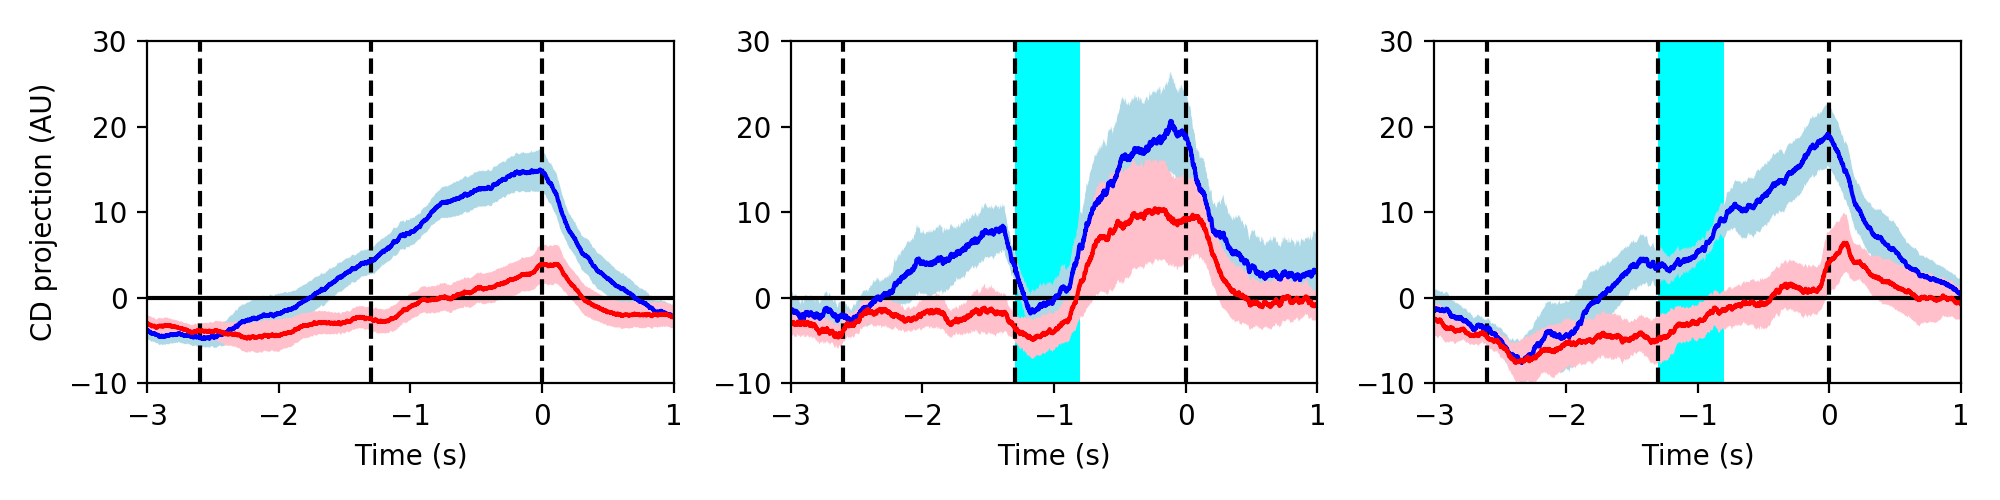

In [20]:
ylim = [-10, 30]
xlim = [-3, 1]

time_window = [-3.5, 2]
bins = np.arange(time_window[0], time_window[1]+0.001, 0.001)
fig3, axs = plt.subplots(1, 3, figsize=(10, 2.5))

for iax, ax in enumerate(axs):
    if iax == 0:
        projected_left, projected_right = light_off.fetch(
            'proj_psth_l', 'proj_psth_r')
    elif iax == 1:
        projected_left, projected_right = fst_act.fetch(
            'proj_psth_l', 'proj_psth_r')
    elif iax == 2:
        projected_left, projected_right = dn_act.fetch(
            'proj_psth_l', 'proj_psth_r')
    mean_psth_l, sem_psth_l = compute_mean_and_sem(projected_left)
    mean_psth_r, sem_psth_r = compute_mean_and_sem(projected_right)
    if iax in [1, 2]:
        ax.fill_between([-1.3, -0.8], [ylim[0], ylim[0]], [ylim[1], ylim[1]], facecolor="cyan")
    for time_point in time_points:
        ax.axvline(x=time_point, color='black', linestyle='dashed')
    ax.axhline(y=0, color='black')
    ax.fill_between(bins, mean_psth_r+sem_psth_r, mean_psth_r-sem_psth_r, facecolor="lightblue")
    ax.plot(bins, mean_psth_r, color="blue")
    ax.fill_between(bins, mean_psth_l+sem_psth_l, mean_psth_l-sem_psth_l, facecolor="pink")
    ax.plot(bins, mean_psth_l, color="red")
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    
    ax.set_xlabel('Time (s)')
    if iax == 0:
        ax.set_ylabel('CD projection (AU)')

fig3.tight_layout()
fig3.savefig('/images/photo_activation.png', dpi=300)